# Plot Maps of ADR Arrays

## Imports

In [1]:
from obspy import UTCDateTime
from obspy.clients import fdsn
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.clients.fdsn    import Client, RoutingClient
from obspy.signal.rotate import rotate2zne
from andbro__savefig import __savefig

import os
import obspy.signal.array_analysis as AA
import matplotlib.pyplot  as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __get_coordinates(config):

    coords = []
    for i, station in enumerate(config['subarray_stations']):

        net, sta = station.split(".")

        inven = config['fdsn_client'][net].get_stations(network=net,
                                                        station=sta,
                                                        channel='BHZ',
                                                        starttime=config['starttime'],
                                                        endtime=config['starttime']+86400,
                                                        level='response'
                                                       )


        l_lon =  float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['longitude'])
        l_lat =  float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['latitude'])
        height = float(inven.get_coordinates('%s.%s..BHZ'%(net,sta))['elevation'])

        coords.append([sta, l_lon, l_lat, height])

    return np.array(coords)

In [4]:
def __get_distances(config):

    import obspy

    cc_lon, cc_lat, cc_height = 0, 0, 0
    for c in config['coordinates']:
        cc_lon += float(c[1])
        cc_lat += float(c[2])
        cc_height += float(c[3])

    cc_lon /= len(config['coordinates'])
    cc_lat /= len(config['coordinates'])
    cc_height /= len(config['coordinates'])

    config['centroid'] = [cc_lon, cc_lat, cc_height]

    dists = []
    for sta, lon, lat, height in config['coordinates']:
        dist_x, dist_y = obspy.signal.util.util_geo_km(float(cc_lon), float(cc_lat), float(lon), float(lat))
        dists.append([dist_x*1000, dist_y*1000, float(height)-float(cc_height)])  #convert unit from km to m

    return np.array(dists)

In [5]:
def __get_aperture_old(config, reference_station=None):

    from numpy import argmax, array, sqrt
    import obspy

    for n, sta in enumerate(config['subarray_stations']):
        if sta == reference_station:
            ref_lon, ref_lat, ref_height = config['coordinates'][n][0], config['coordinates'][n][1], config['coordinates'][n][2]

    dists = []
    for lon, lat, height in config['coordinates']:
        dist_x, dist_y = obspy.signal.util.util_geo_km(ref_lon, ref_lat, lon, lat)
        dists.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  #convert unit from km to m


    aperture = max(abs(array(dists)))
    idx = argmax(abs(array(dists)))

    connection = (ref_lon, ref_lat, config['coordinates'][idx][0], config['coordinates'][idx][1])
    print(f" -> Aperture of Array: {round(aperture,2)} m")
    return aperture, connection

In [6]:
def __get_aperture(config, reference_station=None):

    from numpy import argmax, array, sqrt
    import obspy

    dists, idx = [], []
    for ii, (lon1, lat1, height1) in enumerate(config['coordinates']):
        for jj, (lon2, lat2, height2) in enumerate(config['coordinates']):
            dist_x, dist_y = obspy.signal.util.util_geo_km(lon1, lat1, lon2, lat2)
            dists.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  #convert unit from km to m
            idx.append((ii, jj))

    aperture = max(abs(array(dists)))
    idx_max = int(argmax(abs(array(dists))))
    _ii, _jj = idx[idx_max]

    connection = (config['coordinates'][_ii][0], config['coordinates'][_ii][1],
                  config['coordinates'][_jj][0], config['coordinates'][_jj][1])

    print(f" -> Aperture of Array: {round(aperture,2)} m")
    return aperture, connection

## Get F-band of array

In [8]:
def __get_fband_of_array(aperture, apparent_velocity):
    fmin = 0.02 * apparent_velocity / aperture
    fmax = 0.25 * apparent_velocity / aperture
    return round(fmin, 2), round(fmax, 2)

## PFO ARRAY

In [9]:
## generate configuration object
config3 = {}

## specify client
config3['fdsn_client'] = {"GR":Client('BGR'), "BW":Client("LMU")}
config3['fdsn_client'] = {"GR":Client('BGR'), "BW":Client(base_url="http://jane")}

#starttime for data process
config3['starttime'] = UTCDateTime("2023-04-02T00:00:00")

config3['output_figs'] = data_path+"romy_array/figures/"

config3['array_code'] = "RMY"

#PFO array information
config3['array_stations'] = ["GR.FUR", "BW.FFB1", "BW.FFB2", "BW.FFB3",
                             "BW.TON", "BW.BIB", "BW.GELB", "BW.GRMB", "BW.ALFT",
                            ]


## reference stations for computation of aperture
config3['reference_station'] = "GR.FUR"

# config3['subarray_mask'] = [0, 1, 2, 3, 4, 5, 6, 7, 8] ##all
# config3['subarray_mask'] = [0, 4, 5, 6, 7, 8] ## outer
config3['subarray_mask'] = [0, 1, 2, 3] ##inner

## adjust for sub array
config3['subarray_stations'] = [config3['array_stations'][i] for i in config3['subarray_mask']]

## request inventories
config3['coordinates'] = __get_coordinates(config3)

## get distances
config3['distances'] = __get_distances(config3)


In [35]:
print(config3['coordinates'])


[['FUR' '11.2768' '48.1639' '565.0']
 ['FFB1' '11.275064508' '48.162904091' '572.0']
 ['FFB2' '11.273684' '48.164357' '577.0']
 ['FFB3' '11.276289' '48.164883' '562.0']]


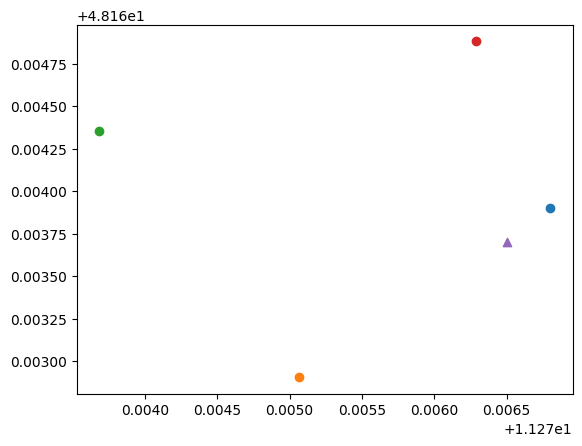

In [54]:
for c in config3['coordinates']:
    plt.scatter(float(c[1]), float(c[2]))

plt.scatter(11.2765, 48.1637, marker="^")

### Get Frequency Band

In [29]:
__get_aperture(config3, reference_station="BW.FFB3")

 -> Aperture of Array: 238.15 m


(238.14673519509145, (11.276289, 48.164883, 11.275065, 48.162904))

In [66]:
apparent_velocity = 3500

fmin, fmax = __get_fband_of_array(aperture=238, apparent_velocity=apparent_velocity)
print("ADRi: ", fmin, fmax)

# fmin, fmax = __get_fband_of_array(aperture=501, apparent_velocity=apparent_velocity)
# print("ADRm: ", fmin, fmax)

fmin, fmax = __get_fband_of_array(aperture=4153, apparent_velocity=apparent_velocity)
print("ADRa: ", fmin, fmax)

ADRi:  0.29 3.68
ADRa:  0.02 0.21


## Single Map

In [85]:
def __plot_array_map(config):

    aper, connect = __get_aperture(config, reference_station=config['reference_station'])

    fig, ax = plt.subplots(1,1, figsize=(7,7))

    font = 14

    for n, c in enumerate(config['coordinates']):

        sta = c[0]

        c = [c[1], c[2], c[3]]

        ax.scatter(c[0], c[1], c='r', marker="^", s=80, zorder=2, edgecolors="k")


        ## add labels
        label_adjustments = {"PY.PFOIX":[0, -4e-4], "PY.BPH01": [0, 2e-4],"PY.BPH02": [0, 2e-4],"PY.BPH03": [1e-4, -4e-4],
                               "PY.BPH04": [-12e-4, 2e-4],"PY.BPH05": [0, 2e-4],"PY.BPH06": [0, 2e-4],
                               "PY.BPH07": [3e-4, 2e-4],"PY.BPH08": [-14e-4, 2e-4],"PY.BPH09": [0, 2e-4],
                               "PY.BPH10": [0, 2e-4],"PY.BPH11": [0, 2e-4],
                               "PY.BPH12": [0, -4e-4],"PY.BPH13": [0,  2e-4],
                            }

        try:
            # x, y = label_adjustments[sta]
            ax.text(c[0], c[1], sta, zorder=2)
        except:
            print(f"{config['array_stations'][n]} has no label..")

    ## plot centroid
#     ax.scatter(config['centroid'][0], config['centroid'][1], s=100, marker="+", c='k',zorder=2)

    ## plot aperture line
    # ax.plot([connect[0], connect[2]], [connect[1], connect[3]], ls=":", zorder=0, color='k')


    ax.set_title(f"{config['array_code']} array stations | aperture: {int(round(aper,0))} m")

    ax.set_xlabel("Longitude (°)", fontsize=font)
    ax.set_ylabel("Latitude (°)", fontsize=font)

    ax.grid(alpha=0.8, zorder=0, ls=":")


    lat_min, lat_max = config3['coordinates'][:, 2].min(), config3['coordinates'][:, 2].max()
    lon_min, lon_max = config3['coordinates'][:, 1].min(), config3['coordinates'][:, 1].max()
    ax.set_xlim(lon_min-0.001, lon_max+0.0015)
    ax.set_ylim(lat_min-0.001, lat_max+0.0015)

    ax.ticklabel_format(useOffset=False, style='plain')

    plt.show();
    return fig

In [86]:
fig = __plot_array_map(config3);

ValueError: too many values to unpack (expected 3)

In [87]:
# __savefig(fig, outpath=config3['output_figs'], outname="PFO_array_map_X", mode="png", dpi=300)

## Array Response

In [73]:
def __compute_array_response(array_stations, longitudes_deg, latitudes_deg, elevations_km, reference_station, axis_type="wave_numer", plot=False):

    from obspy.signal.array_analysis import array_transff_wavenumber, array_transff_freqslowness
    from numpy import linspace, shape, arange, pi

    def __calculateDistanceOfStations(array_stations, longitudes, latitudes):

        from obspy.geodetics import locations2degrees
        from numpy import array, nanmax

        array_stations, longitudes, latitudes = array(array_stations), array(longitudes), array(latitudes)

        N = len(array_stations)

        dist_in_deg = np.zeros((N, N))

        for i, station1 in enumerate(array_stations):
            for j, station2 in enumerate(array_stations):
                dist_in_deg[i][j] = locations2degrees(lat1  = latitudes[i], 
                                                      long1 = longitudes[i], 
                                                      lat2  = latitudes[j], 
                                                      long2 = longitudes[j],
                                                      )

        return dist_in_deg, nanmax(dist_in_deg)*111.0


    def __get_aperture(longitudes, latitudes, reference_longitude, reference_latitude):

        from numpy import argmax, array, sqrt
        from obspy.signal.util import util_geo_km

        distances = []
        for lon, lat in zip(longitudes, latitudes):
            dist_x, dist_y = util_geo_km(reference_longitude, reference_latitude, lon, lat)
            distances.append(sqrt((dist_x*1000)**2+(dist_y*1000)**2))  ## convert unit from km to m

        aperture = max(abs(array(distances)))
                
        return aperture
    
    
    def __plot_array_response(kx, ky, res_func, aperture):

        from numpy import arange
        from obspy.imaging.cm import obspy_sequential
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        import matplotlib.pyplot as plt
        
        fig, ax = plt.subplots(1,1, figsize=(7,7))

        font = 14

        colx = ax.pcolor(kx, ky, res_func.T, cmap=obspy_sequential)

        ax.set_title(f"array response | aperture: {int(round(dist_max*1000, 0))} m")

        ax.set_xlabel('wave number (km$^{-1}$)', fontsize=font)
        ax.set_ylabel('wave number (km$^{-1}$)', fontsize=font)

        ax.grid(alpha=0.1, zorder=0, ls="-", color="white")

        ax.ticklabel_format(useOffset=False, style='plain')

        ## add colorbar
        cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(colx, cax=cax)
    #     cbar.set_label('X+Y')

        plt.show();


    ## ____________________________________________________
        
    dist, dist_max = __calculateDistanceOfStations(array_stations, longitudes_deg, latitudes_deg)

    ref_idx = [n for n, sta in enumerate(array_stations) if sta == reference_station]
    aperture_m = __get_aperture(longitudes_deg, latitudes_deg, longitudes_deg[ref_idx], latitudes_deg[ref_idx])
    print(f" -> Aperture of Array: {round(aperture_m, 2)} m")
    


    ## format coordinates
    coordinates = np.column_stack([longitudes_deg, latitudes_deg, elevations_km])

    if axis_type == "wave_numer":
        
        ## define minimal lambda   
        lambda_min = 2*aperture_m/1000 ## in km
        
        ## define wavenumber limits
        k_max = 4*pi/lambda_min
        k_step = k_max / 100.

        print(" -> k_max = ", k_max, "1/m", "\n -> lambda_min = ", lambda_min, "m" )

        ## compute transfer function as a function of wavenumbe
        transff = array_transff_wavenumber(coordinates, k_max, k_step, coordsys='lonlat')

        ## define wavenumber axes
        x_array = arange(-k_max, k_max + k_step * 1.1, k_step) - k_step / 2.
        y_array = arange(-k_max, k_max + k_step * 1.1, k_step) - k_step / 2.

    elif axis_type == "freq_slowness":

        fmin, fmax, fstep = 0, 10, 0.1
        slim, sstep = 1/(fmax*lamdra_min), 0.1
        
        transff = array_transff_freqslowness(coordinates, slim, sstep, fmin, fmax, fstep, coordsys='lonlat')
        
#         x_array = arange(-fmax, fmax + fstep * 1.1, fstep) - fstep / 2.
        x_array = arange(-slim, slim + sstep * 1.1, sstep) - sstep / 2.
        y_array = arange(-slim, slim + sstep * 1.1, sstep) - sstep / 2.
    
    if plot:
        __plot_array_response(x_array, y_array, transff, aperture_m)
        
    return x_array, y_array, transff

In [88]:
def __plot_array_response(kx, ky, res_func):

    from numpy import arange
    from obspy.imaging.cm import obspy_sequential
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    
    font = 14
    
    colx = ax.pcolor(kx, ky, res_func.T, cmap=obspy_sequential)
    
#     ax.set_title(f"{config['array_code']} array stations | aperture: {int(round(aper,0))} m")
    
    ax.set_xlabel('wave number (km$^{-1}$)', fontsize=font)
    ax.set_ylabel('wave number (km$^{-1}$)', fontsize=font)
    
    ax.grid(alpha=0.1, zorder=0, ls="-", color="white")
        
    ax.ticklabel_format(useOffset=False, style='plain')

    ## add colorbar
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(colx, cax=cax)
#     cbar.set_label('X+Y')
    
    plt.show();
    return fig

In [89]:
x, y, res_func = __compute_array_response(config3['subarray_stations'],
                                            config3['coordinates'][:,0],
                                            config3['coordinates'][:,1],
                                            config3['coordinates'][:,2]/1000,
                                            reference_station=config3['reference_station'],
                                            axis_type="wave_numer",
                                            plot=False
                                           )

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [22]:
print(x.shape, y.shape)

(202,) (202,)


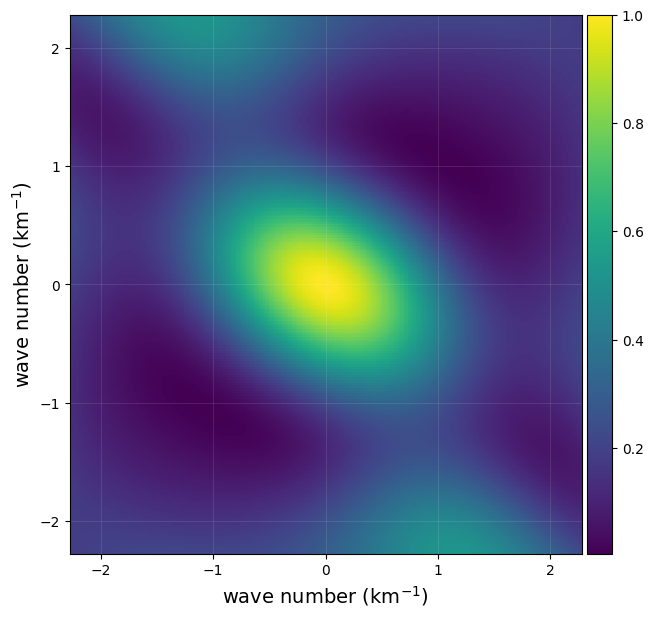

In [23]:
fig = __plot_array_response(x, y, res_func);

In [15]:
__savefig(fig, outpath=config3['output_figs'], outname="PFO_array_response", mode="png", dpi=300)


   -> saving /home/andbro/kilauea-data/BSPF/figures/PFO_array_response.png ...

   -> Done

